In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import date
import copy

In [2]:
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scikit_posthocs as sp

import plot_utils as pu

In [3]:
save = False

In [4]:
import warnings; warnings.simplefilter('ignore')

In [5]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [6]:
CAT2COND, COND2CAT = pu.get_conditions(testonperturbed=False)

In [7]:
CAT2COND

{'original': ['original'],
 'controls': ['length-control', 'random-wl'],
 'information-loss': ['nouns',
  'nounsverbs',
  'nounsverbsadj',
  'contentwords',
  'functionwords',
  'random-nouns'],
 'sentence-meaning': ['sentenceshuffle_passage',
  'sentenceshuffle_topic',
  'sentenceshuffle_random'],
 'word-order': ['scrambled1',
  'scrambled3',
  'scrambled5',
  'scrambled7',
  'backward',
  'lowpmi',
  'lowpmi-random']}

In [8]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "model=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #order double-digit layers at end of list
            double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            return layers
            break

In [9]:
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    best_layernr = 0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
            best_layernr = i
    return max_score, error, best_layernr

In [31]:
def get_best_scores_df(model_identifier, emb_context="Passage", split_coord="Sentence", testonperturbed=False):
    """
    input: model_identifier
    output: dictionary containing the last score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions, categories = [], []
    max_scores = []
    errors = []
    raw_scores = []
    subject_scores = []
    
    subdict = {}
    
    layers = get_all_layers(model_identifier)
    #print(layers)
    
    CAT2COND, COND2CAT = pu.get_conditions(testonperturbed=testonperturbed)
    
    condition_order = list(COND2CAT.keys())
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
                
        if not f"emb_context={emb_context},split_coord={split_coord}" in filename:
            continue 
        
        if not testonperturbed:
            if "teston:" in filename:
                continue
        else:
            if not "teston:" in filename:
                continue

        if "constant-control" in filename:
            continue
                        

        model_name = filename.split(",")[1]
        bm = filename.split(",")[0]
        
        if bm == "benchmark=Pereira2018-encoding": #exclude old orignial bm in different format
            continue
        
        if "model=" + model_identifier == model_name:
            
            condition = bm.split("benchmark=Pereira2018-encoding-")[-1]
                
#             print(filename, sys.stdout.flush())
            
            #clean name
            condition = re.sub("perturb-","",condition)
            if not any(x in condition for x in ["1", "3", "5", "7"]):
                condition = re.sub("scrambled-","",condition)
            
            if testonperturbed:
                condition = re.sub("scrambled","scr",condition)
                
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result_all = out['data']
            result = out['data'].values

            max_score, error, best_layernr = get_max_score(result)
            best_layer = layers[best_layernr]

            raw_score = result_all.raw.raw #unnormalized, ungrouped lang. data *****QUESTION CK*****
            best_layer_raw = raw_score[{"layer": [layer == best_layer for layer in raw_score["layer"]]}]
#                 final_layer_raw = final_layer_raw.fillna(0)
            raw_scores.append(best_layer_raw.values)

            subject_score = best_layer_raw.groupby('subject').median().values #is this correct? 
            subject_scores.append(subject_score)

            # append to dict
            subdict[condition] = subject_score #keeping variance across subjects here

            #print(result, '\n\n')
#                 max_score, error = get_max_score(result)

            conditions.append(condition)
            categories.append(COND2CAT[condition])
            max_scores.append(max_score)
            errors.append(error/1.48) #TODO TAKE OUT *****QUESTION CK*****
            
    index = conditions
    df = pd.DataFrame({'score': max_scores, 'error': errors, 'condition': conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=condition_order)
    scores_df = df.sort_values(by='condition')
    scores_df['category'] = [COND2CAT[elm] for elm in list(scores_df['condition'])]
    
    # Currently not outputted
    df_stats = pd.DataFrame({'score': raw_scores}, index=conditions)
    df_substats = pd.DataFrame({'score': subject_scores}, index=conditions)
    
    # Transform subdict to statsmodel api form:
    x = subdict.copy()
    subdf = pd.DataFrame(x)
    subdf = subdf.melt(var_name='groups', value_name='values')
    
    subdf['groups'] = pd.Categorical(subdf['groups'], categories=condition_order, ordered=True)
    subdf = subdf.sort_values('groups')
    
    subdf['category'] = [COND2CAT[elm] for elm in list(subdf['groups'])]
    
    #clean names
    subdf['groups'] = subdf['groups'].str.replace("teston:","")
    subdf['groups'] = subdf['groups'].replace(
    {'sentenceshuffle_random': 'sent_random',
    'sentenceshuffle_passage': 'sent_passage',
    'sentenceshuffle_topic': 'sent_topic',
    'scr1': 'scrambled1',
    'scr3': 'scrambled3',
    'scr5': 'scrambled5',
    'scr7': 'scrambled7'}
    )
    
    return scores_df, subdict, subdf

In [32]:
scores, subdict, subdf = get_best_scores_df("gpt2-xl")
subdf

,groups,values,category
130,original,0.311779,original
132,original,0.308316,original
133,original,0.339043,original
134,original,0.357018,original
135,original,0.395303,original
...,...,...,...
126,lowpmi-random,0.397781,word-order
127,lowpmi-random,0.383665,word-order
128,lowpmi-random,0.379543,word-order
129,lowpmi-random,0.338729,word-order


In [33]:
scores

,score,error,condition,category
13,1.107199,0.095838,original,original
0,0.104821,0.037137,length-control,controls
14,0.925266,0.107413,random-wl,controls
3,0.990527,0.127832,nouns,information-loss
4,1.049179,0.054952,nounsverbs,information-loss
5,1.074820,0.100728,nounsverbsadj,information-loss
1,1.069320,0.127847,contentwords,information-loss
2,0.532726,0.075207,functionwords,information-loss
6,0.850396,0.065132,random-nouns,information-loss
7,1.013114,0.075485,sentenceshuffle_passage,sentence-meaning


In [34]:
save=True

In [56]:
def anova_ttest(model_identifier, emb_context="Passage", split_coord="Sentence",
                testonperturbed=False, category=None):
    
    scores, subdict, subdf = get_best_scores_df(model_identifier=model_identifier,
                                                emb_context=emb_context, split_coord=split_coord, 
                                                testonperturbed=testonperturbed)
    
    if category:
        original_df = subdf[subdf['category']=='original']
        cat_subdf = subdf[subdf['category']==category]
        use_subdf = pd.concat([original_df,cat_subdf])
    else:
        use_subdf = subdf
    
    ttest = sp.posthoc_ttest(use_subdf, val_col='values', group_col='groups', p_adjust='fdr_bh')
    ttest_df = pd.DataFrame(ttest)
    ttestsave = f'{model_identifier}_posthocttest_{category}'
    if testonperturbed:
        ttestsave += '_testonperturbed'
    ttest_df.to_csv(f'images/{ttestsave}.csv')
        
    plt.figure(figsize=(10,10))
    sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    plt.title('{}'.format(model_identifier),fontsize=18)
    plt.subplots_adjust(top=0.8) 
    
    savename = f'images/stats-match-to-brain_{model_identifier}'
    
    if testonperturbed:
        savename +='_testonperturbed'
    
    if save:
        savename = f'{savename}.png'
        plt.savefig(savename, bbox_inches='tight', dpi=240)
    plt.show()

    return ttest

In [47]:
# Plot arguments
#args = {'annot':ttest}
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.55, 0.04, 0.3]}

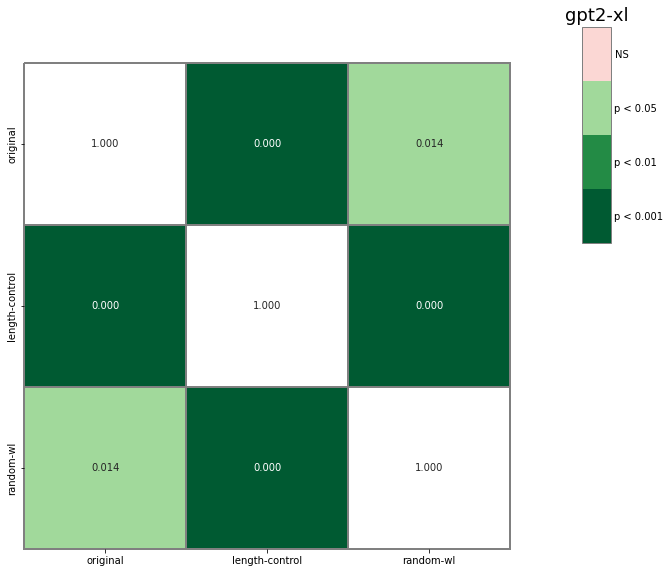

In [48]:
g=anova_ttest('gpt2-xl', category='controls')

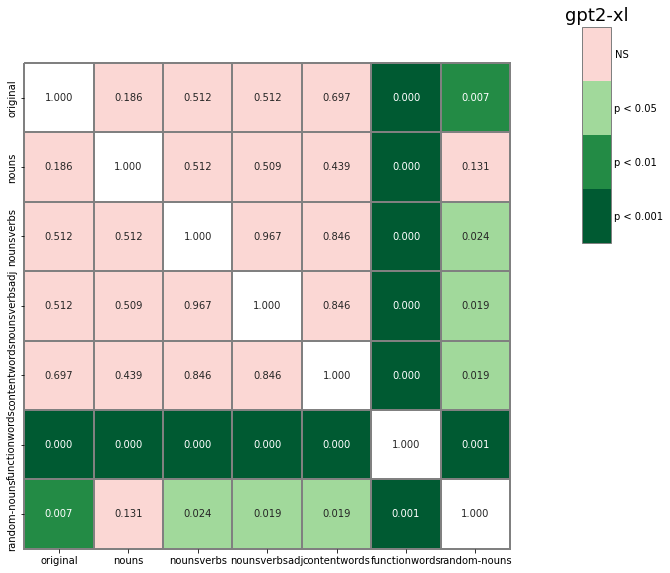

In [49]:
g=anova_ttest('gpt2-xl', category='information-loss')

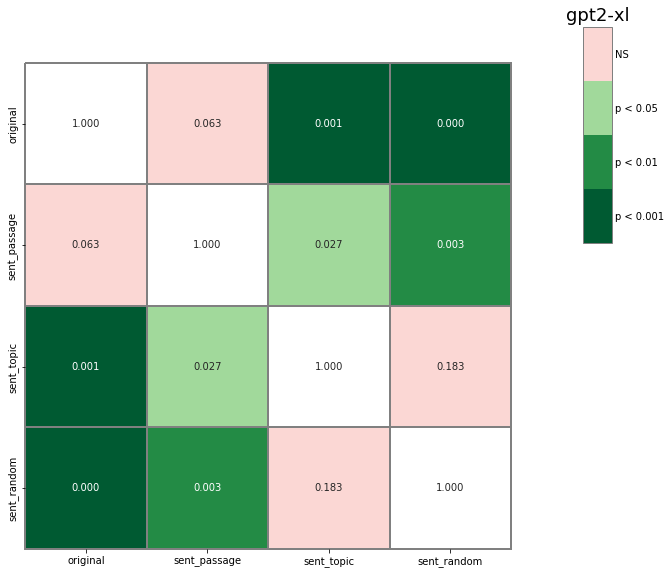

In [50]:
g=anova_ttest('gpt2-xl', category='sentence-meaning')

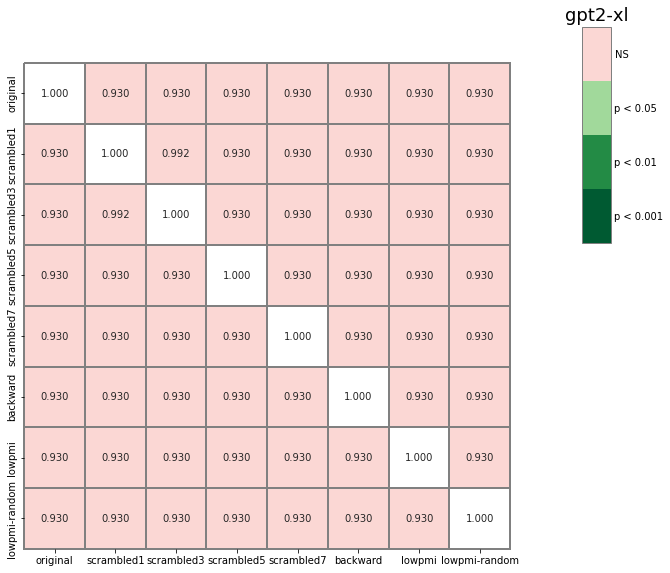

In [51]:
g=anova_ttest('gpt2-xl', category='word-order')

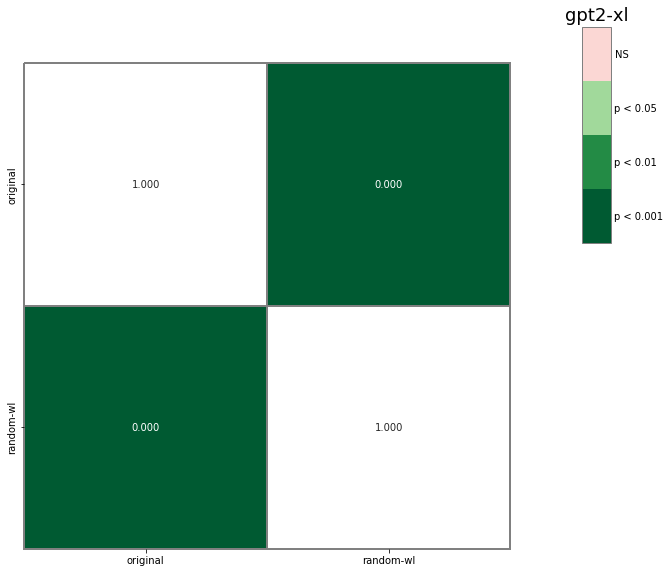

In [52]:
g=anova_ttest('gpt2-xl', category='controls', testonperturbed=True)

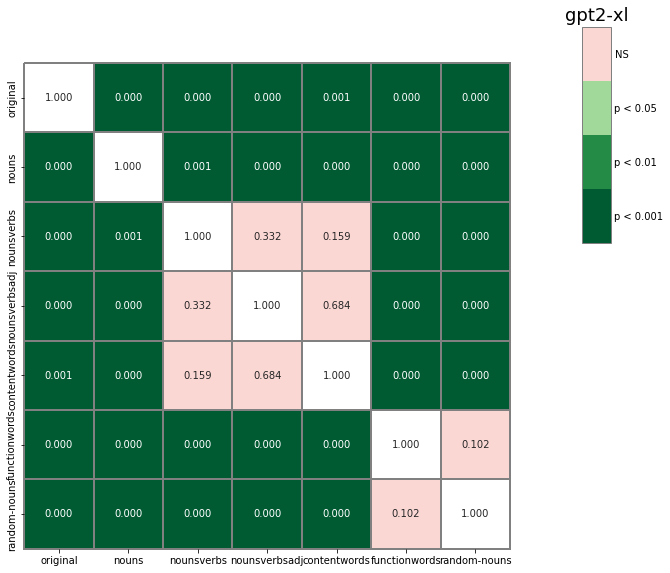

In [53]:
g=anova_ttest('gpt2-xl', category='information-loss', testonperturbed=True)

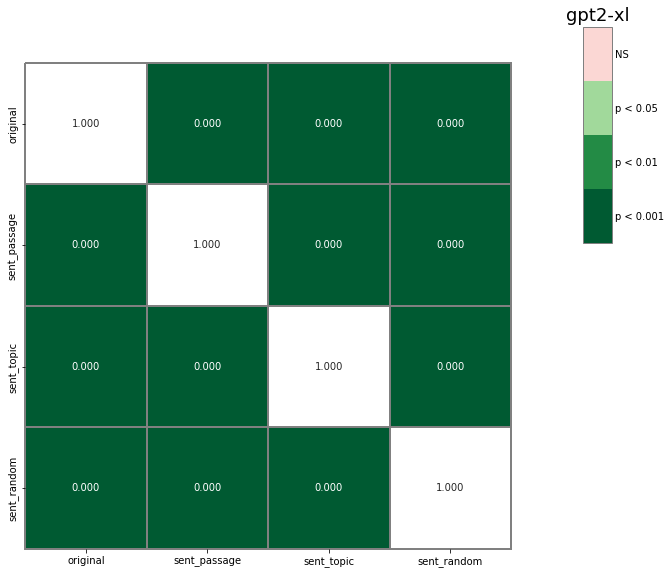

In [54]:
g=anova_ttest('gpt2-xl', category='sentence-meaning', testonperturbed=True)

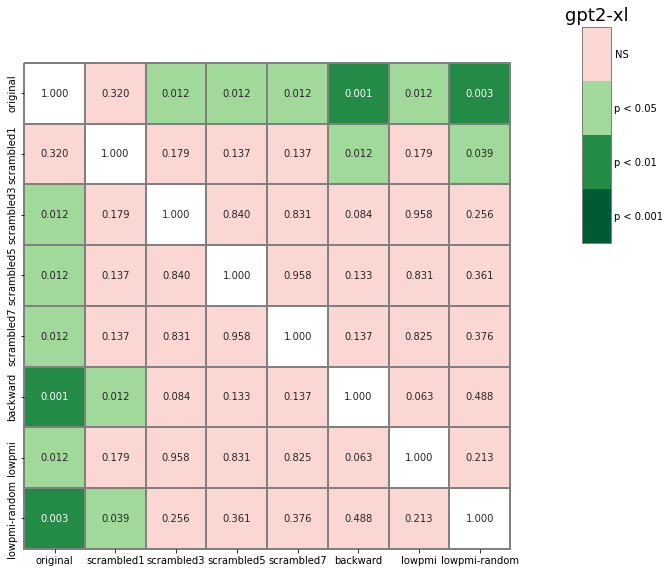

In [55]:
g=anova_ttest('gpt2-xl', category='word-order', testonperturbed=True)